# Import 

# PEP 8

In [1]:
#%load_ext pycodestyle_magic
#%pycodestyle_on

## Librairies

In [2]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing, cluster, pipeline, compose, decomposition
import plotly.express as px
from sklearn import manifold
from mypca import *
from sklearn import metrics
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


## Données

In [3]:
customer = pd.read_csv('customer.csv', index_col='customer_unique_id')

In [4]:
customer['same_state'] = customer['same_state'].astype('category')

In [5]:
customer.shape

(93894, 15)

In [6]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93894 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   basket_avg            93894 non-null  float64 
 1   last_purchase         93894 non-null  int64   
 2   avg_review_score      93894 non-null  float64 
 3   total_amount          93894 non-null  float64 
 4   avg_vol_pack          93894 non-null  float64 
 5   payment_type          93894 non-null  object  
 6   avg_delivery_time     93894 non-null  float64 
 7   same_state            93894 non-null  category
 8   avg_freight_value     93894 non-null  float64 
 9   avg_weight            93894 non-null  float64 
 10  payment_installments  93894 non-null  float64 
 11  lat                   93894 non-null  float64 
 12  long                  93894 non-null  float64 
 13  frequency             93894 non-null  int64   
 14  c

## Preparation

In [7]:
num = list(customer.select_dtypes(['float', 'int']).columns)
cat = list(customer.select_dtypes(['object', 'category']).columns)

num.remove('lat')
num.remove('long')

In [8]:
# One hot encoding
one_hot_sparse = preprocessing.OneHotEncoder(sparse=True)
one_hot = preprocessing.OneHotEncoder(sparse=False)

# Standard Scaler
scaler = preprocessing.StandardScaler()

# log x +1
log = preprocessing.FunctionTransformer(func=np.log1p)

# Valeur absolue
abso = preprocessing.FunctionTransformer(func=np.abs)

# Pipelines
std_log = pipeline.make_pipeline(log, scaler)
abso_std_log = pipeline.make_pipeline(abso, log, scaler)

In [9]:
# preprocesseur v1

preprocessor = compose.make_column_transformer(
    (abso_std_log, num),
    (one_hot, cat)
)

In [10]:
# preprocesseur v2 (sparse data)

preprocessor_sparse = compose.make_column_transformer(
    (abso_std_log, num),
    (one_hot_sparse, cat)
)

## Dimensionality reduction : PCA

In [11]:
X = customer
n_comp = 6  # Nombre de dimensions
features = customer.columns  # Extraction des noms de variables
names = customer.index  # Extraction des noms de pays

In [12]:
pca = decomposition.PCA(n_components=n_comp)

pipeline_pca = pipeline.make_pipeline(preprocessor, pca)

In [13]:
pipeline_pca.fit(X)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(func=<ufunc 'absolute'>)),
                                                                  ('functiontransformer-2',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['basket_avg',
                                                   'last_purchase',
                                                   'avg_review_score',
                                                   'total_amount',
                                               

In [14]:
# Variance expliquée

print(pipeline_pca[1].explained_variance_ratio_)

[0.25533063 0.13820664 0.10726482 0.08614799 0.08311112 0.08184958]


In [15]:
labels = pd.get_dummies(X).columns

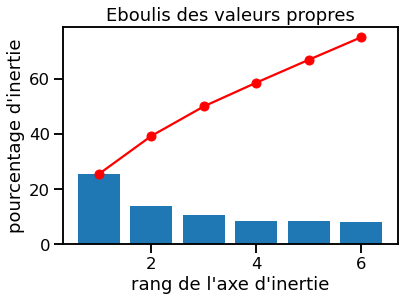

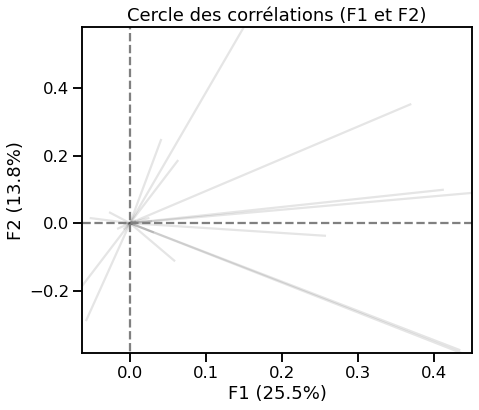

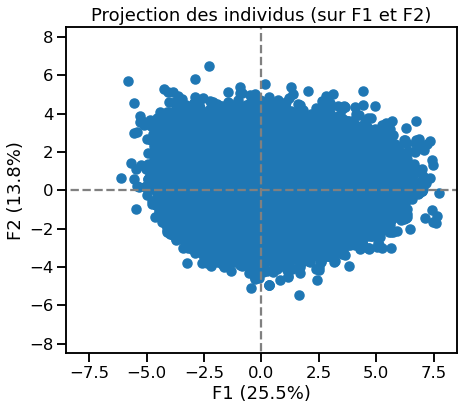

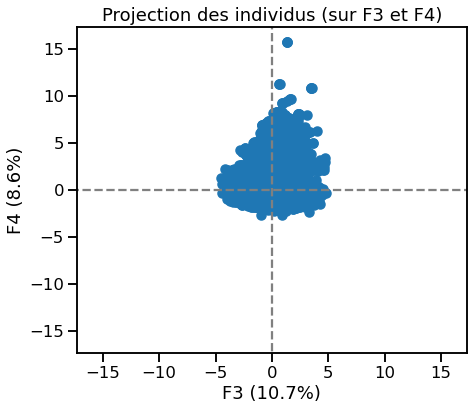

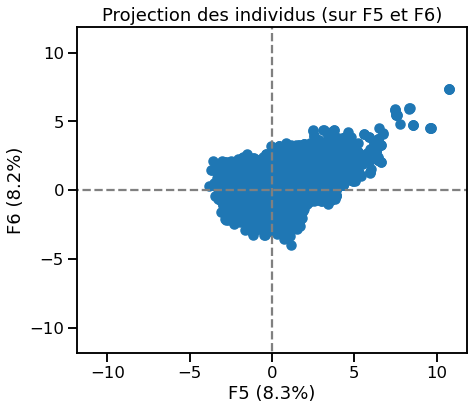

In [16]:
# Eboulis des valeurs propres
display_scree_plot(pipeline_pca[1])

# Cercle des corrélations
pcs = pipeline_pca[1].components_
display_circles(pcs, n_comp, pipeline_pca[1], [(0,1)], labels = None , title='Cercles_corr')

# Projection des individus
X_projected = pipeline_pca.transform(X)
display_factorial_planes(X_projected, n_comp, pipeline_pca[1], [(0,1),(2,3),(4,5)], illustrative_var=None, title='Projection_indiv')

plt.show()

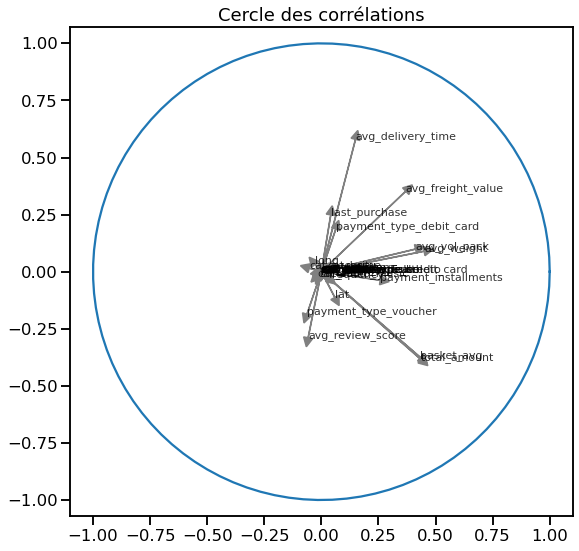

In [17]:
# Cercle des corrélations
(fig, ax) = plt.subplots(figsize=(9, 9))
for i in range(0, pipeline_pca[1].components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  # 0 for PC1
             pca.components_[1, i],  # 1 for PC2
             head_width=0.04,
             head_length=0.04,
             color='gray'
             )

    plt.text(pca.components_[0, i],
             pca.components_[1, i],
             labels[i],
             fontsize=11,
             alpha=0.8
             )


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Cercle des corrélations')
plt.show()

## Clustering

### K-Means

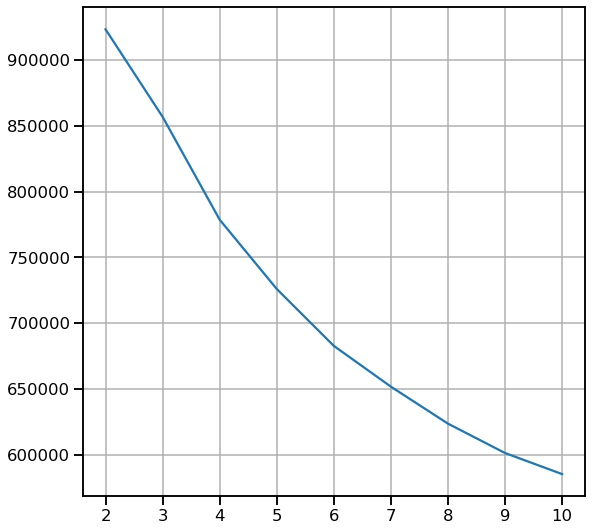

CPU times: user 1min 19s, sys: 10.8 s, total: 1min 30s
Wall time: 12.6 s


In [18]:
# méthode du coude avec le calcul de l'inertie

inertia = []
nb_cluster_max = 10
for z in range(2,nb_cluster_max+1):
    kmeans = cluster.KMeans(n_clusters = z)
    k_pipe = pipeline.make_pipeline(preprocessor, kmeans)
    k_pipe.fit(X)
    inertia.append(k_pipe[1].inertia_)
    
x = np.arange(2,nb_cluster_max+1)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_xticks(ticks=np.arange(0,25,1))
ax.grid(b=True)
plt.plot(x, inertia)
plt.show()

In [19]:
# défintions d'un code couleur pour chaque groupe

cmap = {
    0:'Crimson',
    1:'Sienna',
    2:'DarkBlue',
    3:'Orange',
    4:'Black',
    5:'Silver',
    6:'Chartreuse',
    7:'Fuchsia',
    8:'gray',
    9:'gray',
    10:'gray',
    11:'gray',
}


cmap_object = {
    '0':'Crimson',
    '1':'Sienna',
    '2':'DarkBlue',
    '3':'Orange',
    '4':'Black',
    '5':'Silver',
    '6':'Chartreuse',
    '7':'Fuchsia'
}

cmap_list = [
    'Crimson',
    'Sienna',
    'DarkBlue',
    'Orange',
    'Black',
    'Silver',
    'Chartreuse',
    'Fuchsia'
]


For n_clusters = 2 The average silhouette_score is : 0.1518175856710204
For n_clusters = 3 The average silhouette_score is : 0.11066377930723044
For n_clusters = 4 The average silhouette_score is : 0.11629562835924441
For n_clusters = 5 The average silhouette_score is : 0.13352957054471407
For n_clusters = 6 The average silhouette_score is : 0.12023345482766709
For n_clusters = 7 The average silhouette_score is : 0.11815020619153738
For n_clusters = 8 The average silhouette_score is : 0.12085050776424704
For n_clusters = 9 The average silhouette_score is : 0.11480730077671662
For n_clusters = 10 The average silhouette_score is : 0.11289516177795529


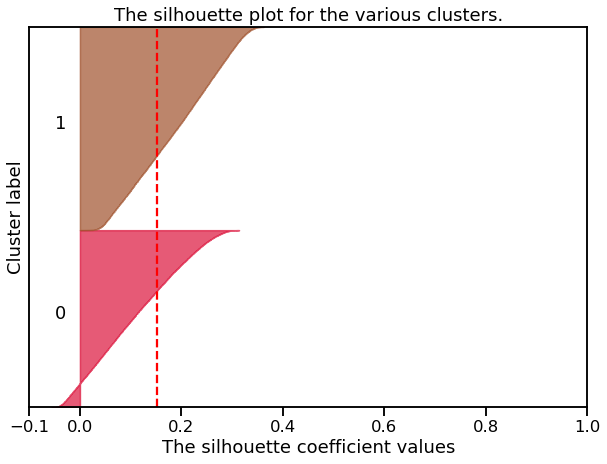

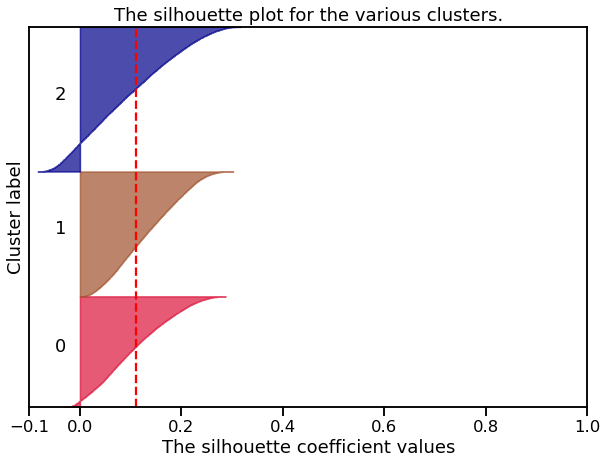

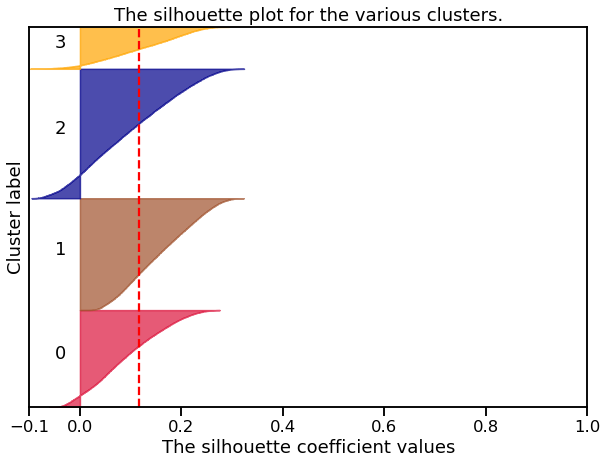

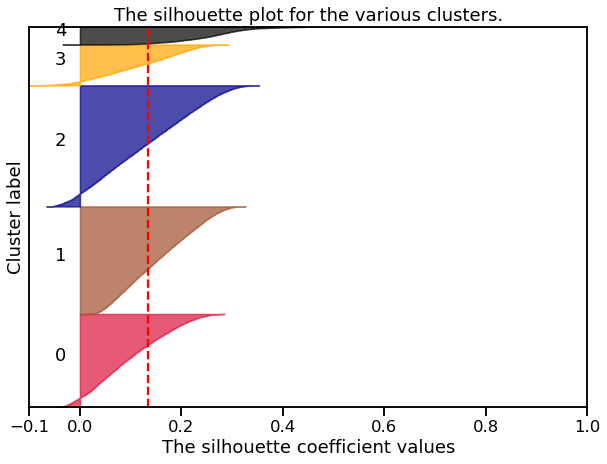

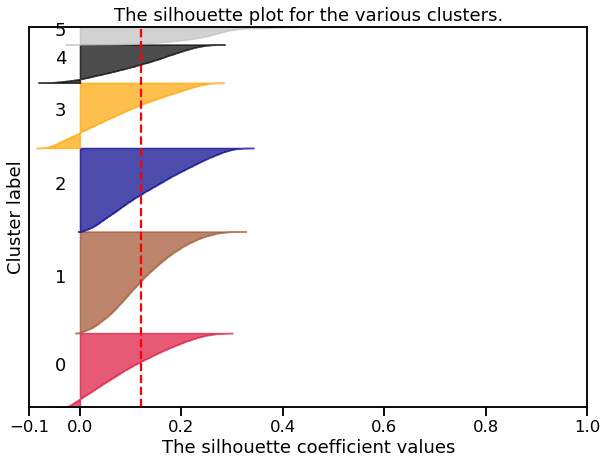

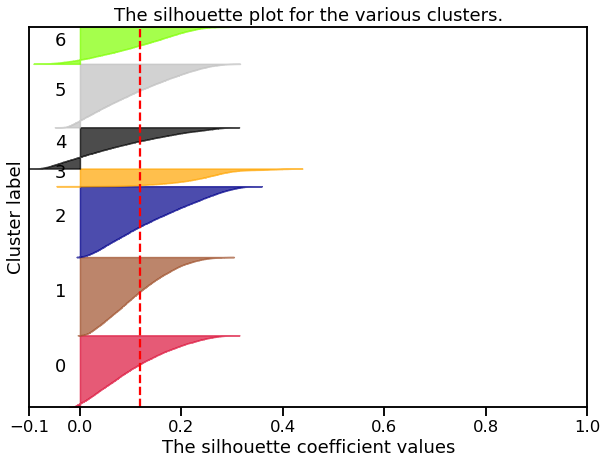

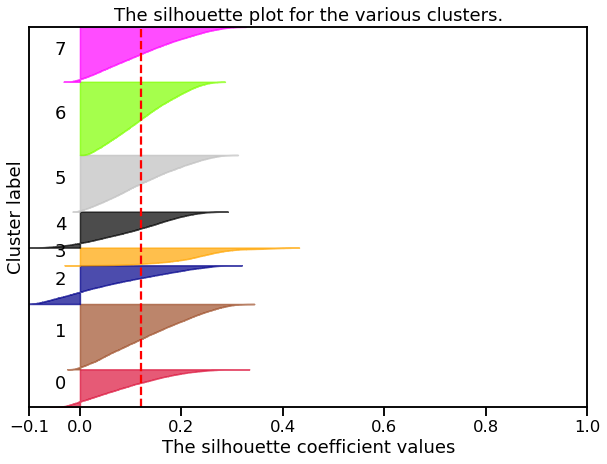

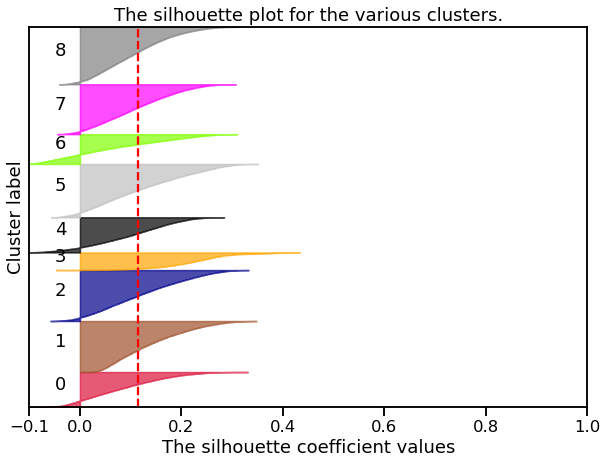

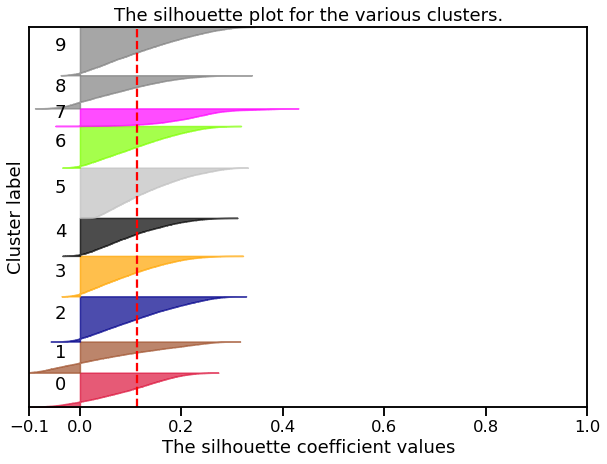

CPU times: user 1h 11s, sys: 26min 27s, total: 1h 26min 38s
Wall time: 23min 5s


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

silhouette = []

range_n_clusters = range(2,nb_cluster_max+1)

prep_X = preprocessor.fit_transform(X)

for n_clusters in range_n_clusters:
    # Création d'un subplot
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(prep_X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(prep_X)
    silhouette_avg = silhouette_score(prep_X, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Calcul du score silhouette
    sample_silhouette_values = silhouette_samples(prep_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color[i], edgecolor=color[i], alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

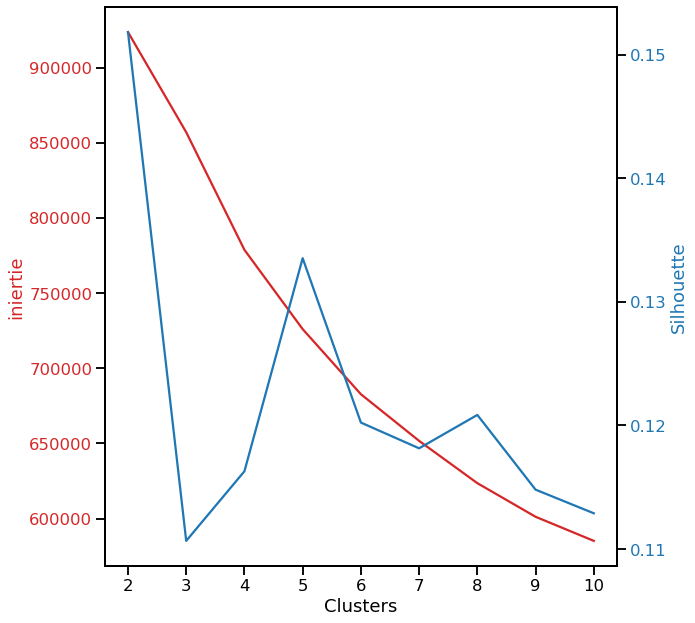

In [24]:
# Création d'un grapique pour afficher l'inertie et le silhouette score sur un même axe X

fig, ax1 = plt.subplots(figsize=(10,9))

color = 'tab:red'
ax1.set_xlabel('Clusters')
ax1.set_ylabel('iniertie', color=color)
ax1.plot(list(range_n_clusters), inertia, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Deuxième axe qui partage l'axe x

color = 'tab:blue'
ax2.set_ylabel('Silhouette', color=color)  
ax2.plot(list(range_n_clusters), silhouette, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [25]:
# Instanciation de l'algorithme du k-means avec 8 groupes

kmeans = cluster.KMeans(n_clusters = 8)
k_pipe = pipeline.make_pipeline(preprocessor, kmeans).fit(X)
pred = k_pipe.predict(X)

### Visualisation des clusters

In [95]:
# Modification de la fonction pour visualiser les clusters avec des couleurs consistantes

def display_factorial_planes_sns(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, title=None, cmap=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                fig, ax = plt.subplots(figsize=(10,10))
                sns.scatterplot(x=X_projected[:, d1], y=X_projected[:, d2], hue=illustrative_var, alpha=alpha,  palette=cmap)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.savefig(title)
            plt.show(block=False)


<Figure size 504x432 with 0 Axes>

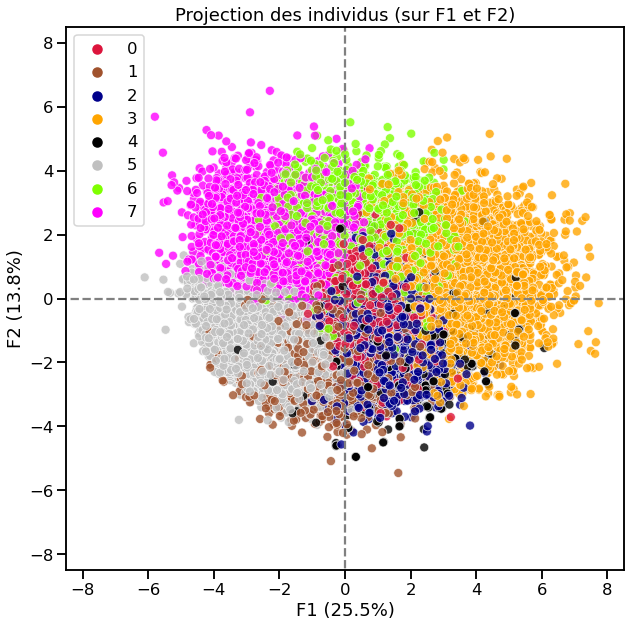

<Figure size 504x432 with 0 Axes>

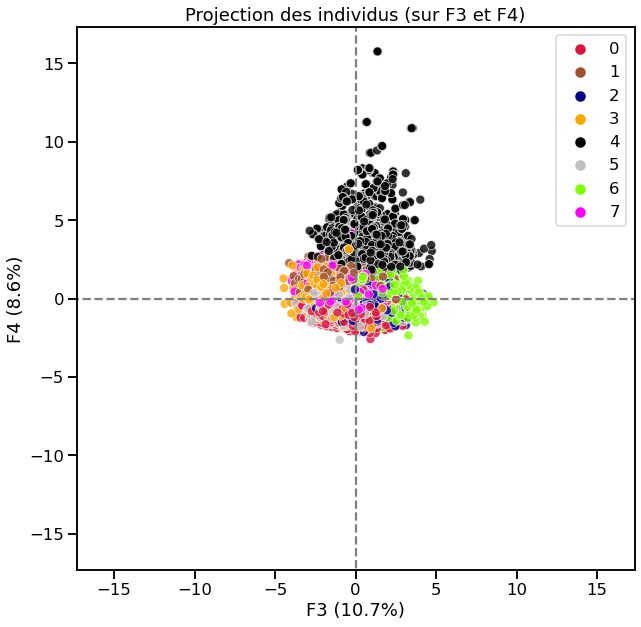

<Figure size 504x432 with 0 Axes>

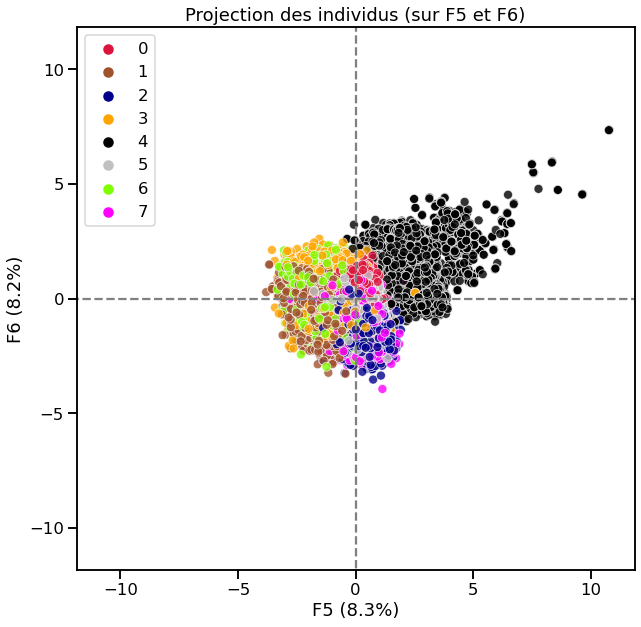

In [96]:
display_factorial_planes_sns(X_projected, n_comp, pipeline_pca[1], [(0,1),(2,3),(4,5)], illustrative_var=pred, title='Projection_indiv', alpha=0.8, cmap=cmap)

In [30]:
# Attribution des groupes

customer['group'] = pred

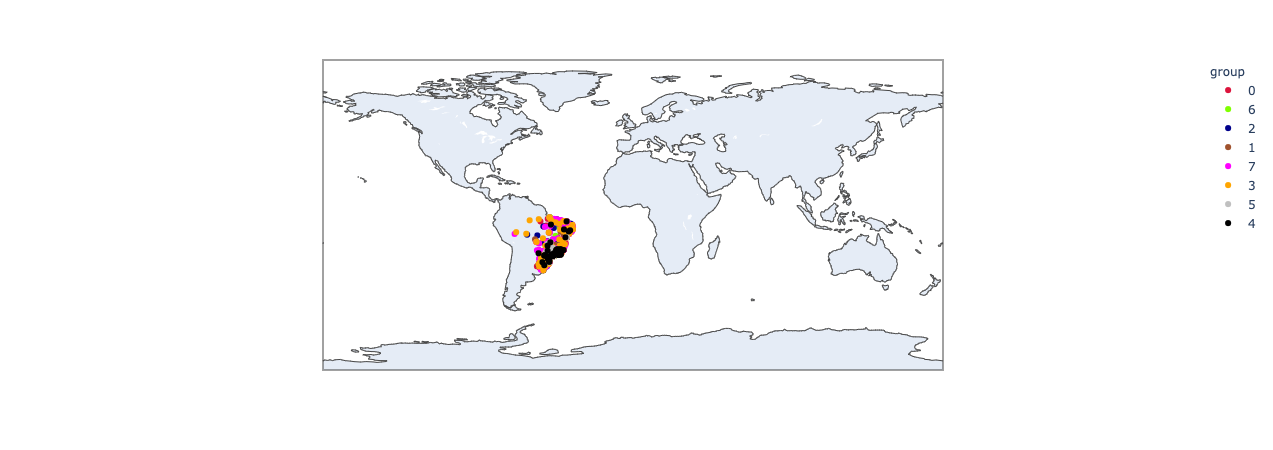

In [83]:
# Origine géographique des clients en fonction du groupe

sample = customer.sample(1500, random_state= 42)

sample['group'] = sample['group'].astype('str')  # Modification du type de variable en discrète

fig = px.scatter_geo(sample,
                     lat=sample.lat,
                     lon=sample.long,
                     color=sample.group,
                    color_discrete_map=cmap_object)
fig.show()

In [34]:
# Visualisation des groupes à l'aide du T-SNE

tsne = manifold.TSNE(random_state=42)
tsne_pipe = pipeline.make_pipeline(preprocessor, tsne)
X_tsne = tsne_pipe.fit_transform(X)

x = X_tsne[:,0]
y = X_tsne[:,1]

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.scatterplot(x=x,y=y, hue=pred, palette = cmap)

plt.show()

CPU times: user 52min 2s, sys: 4min 13s, total: 56min 15s
Wall time: 9min 14s


In [80]:
customer_dum.columns

Index(['basket_avg', 'last_purchase', 'avg_review_score', 'total_amount',
       'avg_vol_pack', 'avg_delivery_time', 'avg_freight_value', 'avg_weight',
       'payment_installments', 'lat', 'long', 'frequency', 'group',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher', 'same_state_False',
       'same_state_True', 'cat_appliance', 'cat_art', 'cat_audio_music',
       'cat_auto', 'cat_beauty_health', 'cat_book', 'cat_business',
       'cat_children', 'cat_construction', 'cat_fashion', 'cat_food',
       'cat_garden', 'cat_gift', 'cat_home', 'cat_misc', 'cat_office',
       'cat_party', 'cat_pet', 'cat_security', 'cat_sport', 'cat_technology',
       'cat_travel'],
      dtype='object')

In [82]:
# Analyse des groupes 

pd.pandas.set_option('display.max_columns', None)

customer_dum = pd.get_dummies(customer)

customer_dum.groupby('group').agg({
    'basket_avg' : 'mean',
    'last_purchase': 'mean',
    'avg_review_score': 'mean',
    'total_amount': 'mean',
    'avg_vol_pack': 'mean',
    'avg_delivery_time': 'mean',
    'avg_freight_value': 'mean',
    'avg_weight': 'mean',
    'payment_installments': lambda x:x.value_counts().index[0],
    'lat': 'mean',
    'long': 'mean',
    'frequency': 'mean',
    'payment_type_boleto': lambda x :x.value_counts().index[0],
    'payment_type_credit_card': lambda x :x.value_counts().index[0],
    'payment_type_debit_card': lambda x :x.value_counts().index[0],
    'payment_type_voucher': lambda x :x.value_counts().index[0],
    'same_state_False': lambda x :x.value_counts().index[0],
    'same_state_True': lambda x :x.value_counts().index[0],
    'cat_appliance' : lambda x :x.value_counts().index[0],
    'cat_art' : lambda x :x.value_counts().index[0],
    'cat_audio_music' : lambda x :x.value_counts().index[0],
    'cat_auto' : lambda x :x.value_counts().index[0],
    'cat_beauty_health' : lambda x :x.value_counts().index[0],
    'cat_book' : lambda x :x.value_counts().index[0],
    'cat_business' : lambda x :x.value_counts().index[0],
    'cat_children' : lambda x :x.value_counts().index[0],
    'cat_construction' : lambda x :x.value_counts().index[0],
    'cat_fashion' : lambda x :x.value_counts().index[0],
    'cat_food' : lambda x :x.value_counts().index[0],
    'cat_garden' : lambda x :x.value_counts().index[0],
    'cat_gift' : lambda x :x.value_counts().index[0],
    'cat_home' : lambda x :x.value_counts().index[0],
    'cat_misc' : lambda x :x.value_counts().index[0],
    'cat_office' : lambda x :x.value_counts().index[0],
    'cat_party' : lambda x :x.value_counts().index[0],
    'cat_pet' : lambda x :x.value_counts().index[0],
    'cat_security' : lambda x :x.value_counts().index[0],
    'cat_sport' : lambda x :x.value_counts().index[0],
    'cat_technology' : lambda x :x.value_counts().index[0],
    'cat_travel' : lambda x :x.value_counts().index[0],    
})

,basket_avg,last_purchase,avg_review_score,total_amount,avg_vol_pack,avg_delivery_time,avg_freight_value,avg_weight,payment_installments,lat,long,frequency,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,same_state_False,same_state_True,cat_appliance,cat_art,cat_audio_music,cat_auto,cat_beauty_health,cat_book,cat_business,cat_children,cat_construction,cat_fashion,cat_food,cat_garden,cat_gift,cat_home,cat_misc,cat_office,cat_party,cat_pet,cat_security,cat_sport,cat_technology,cat_travel
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,22932.901069,292.895995,4.554160,22932.901069,17138.132150,12.034134,18.100808,2084.252266,1.0,-21.904883,-46.392092,1.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15874.470694,38.517116,4.549110,15874.470694,8988.802488,6.980058,18.422470,1057.622661,1.0,-21.778705,-46.338572,1.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37414.871632,284.583715,4.540212,37414.871632,11144.992139,11.153477,18.205779,1366.572769,10.0,-21.435099,-46.148548,1.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60399.853106,234.186609,4.161934,60764.894747,57945.880097,14.461721,47.604324,9805.582339,1.0,-20.293059,-45.912291,1.001048,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21736.655652,216.162839,4.172317,47101.677253,14641.323044,11.650828,18.979401,1966.259874,1.0,-21.618458,-46.281499,2.158934,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6344.372276,232.689436,4.478202,6344.418504,5321.357271,5.125258,9.625395,505.210218,1.0,-23.099203,-46.764583,1.000074,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,22221.474701,242.977575,1.139903,22221.474701,12137.486859,21.790512,19.047088,1533.214537,1.0,-20.612303,-45.528922,1.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2830.806054,274.218256,4.403338,2830.867956,5255.362159,14.987090,18.965344,534.922941,1.0,-19.029212,-45.924284,1.000248,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Analyse des groupes 

def RadarPlot(data=None, group=None, nb_features=None) :
    
    ### Créer un diagramme de Kiviat en fonction des principales variables ###
    
    prep = preprocessing.MinMaxScaler(feature_range=(1,5))
    customer_dum = pd.get_dummies(customer)

    radar_df = customer_dum.groupby('group').agg({
    'basket_avg' : 'mean',
    'last_purchase': 'mean',
    'avg_review_score': 'mean',
    'total_amount': 'mean',
    'avg_vol_pack': 'mean',
    'avg_delivery_time': 'mean',
    'avg_freight_value': 'mean',
    'avg_weight': 'mean',
    'payment_installments': lambda x:x.value_counts().index[0],
    'lat': 'mean',
    'long': 'mean',
    'frequency': 'mean',
    'same_state_True': lambda x :x.value_counts().index[0]    
    })
    
    radar_df = radar_df.drop(['lat', 'long'], axis=1)  
    radar_scaler = pipeline.make_pipeline(abso, log, prep)
    temp = radar_scaler.fit_transform(radar_df)
    temp = pd.DataFrame(index=radar_df.index, columns=radar_df.columns, data=temp)
    temp = temp.T
    temp = temp.iloc[:nb_features]
    fig = px.line_polar(temp, r=group,  theta=temp.index, line_close=True)
    fig.update_layout(polar = dict(
        radialaxis = dict(showticklabels=False, ticks='')),
                      title = 'Radarplot of group {}'.format(group),
                      title_x=0.5
    )
    fig.show()

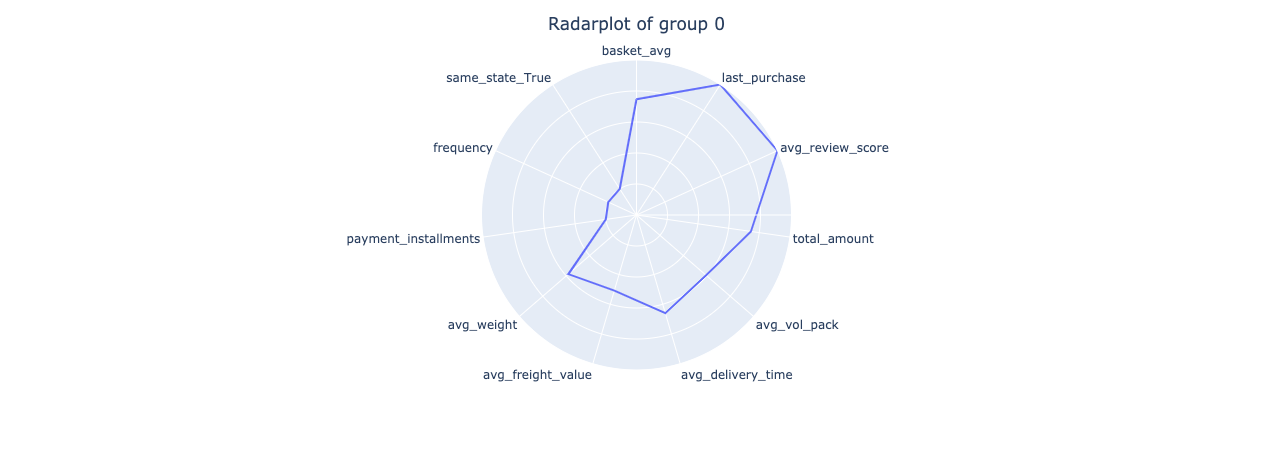

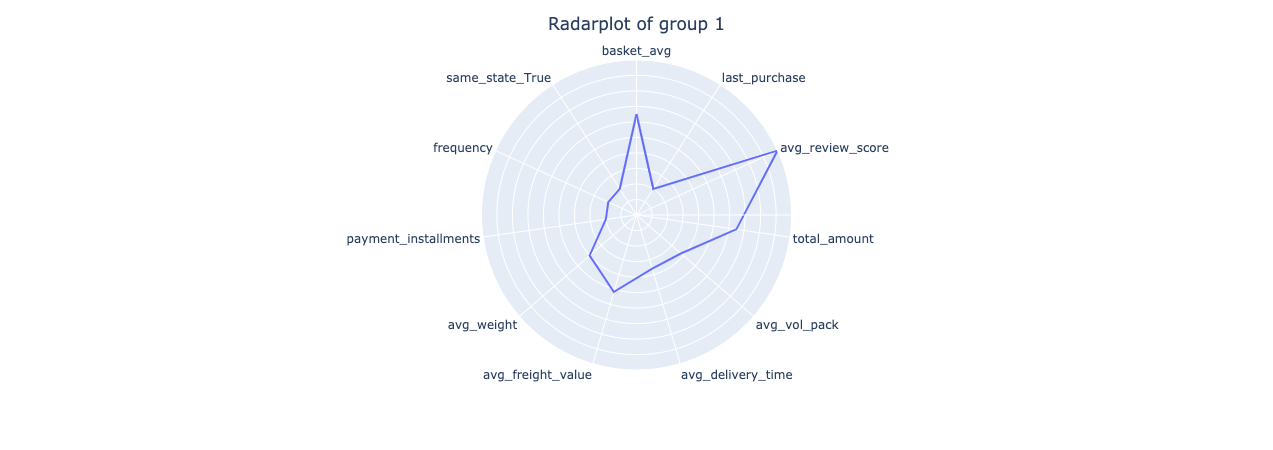

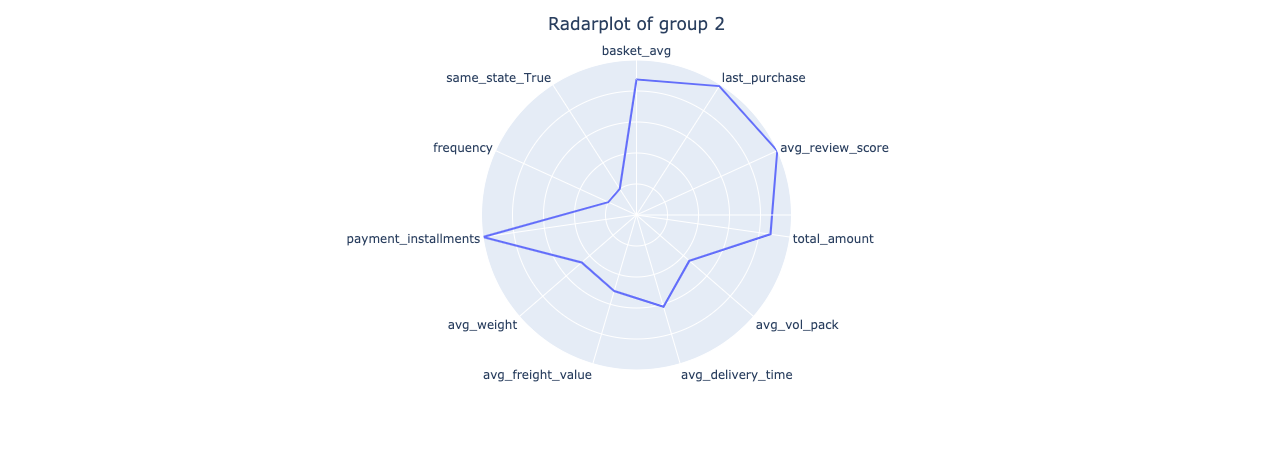

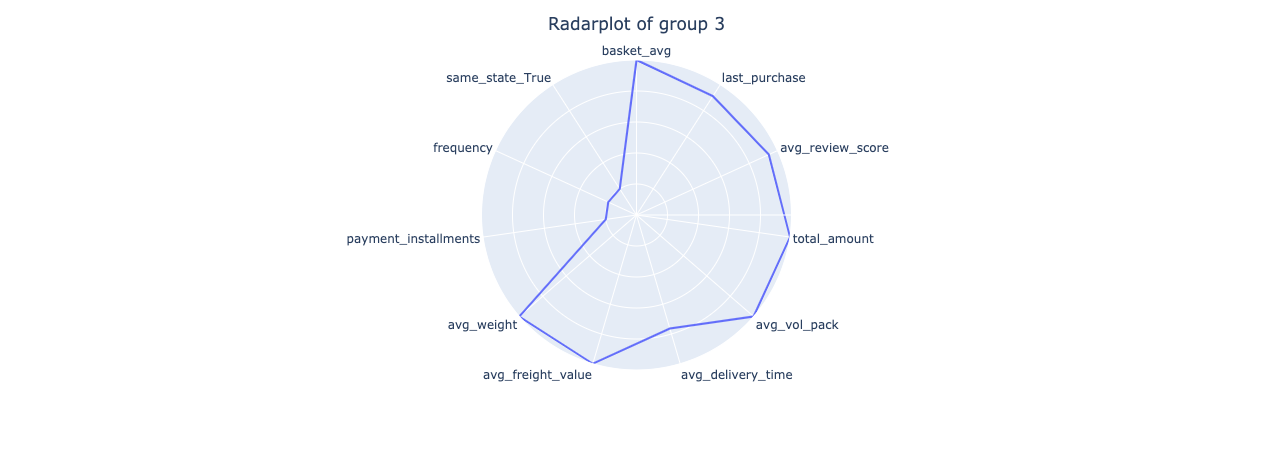

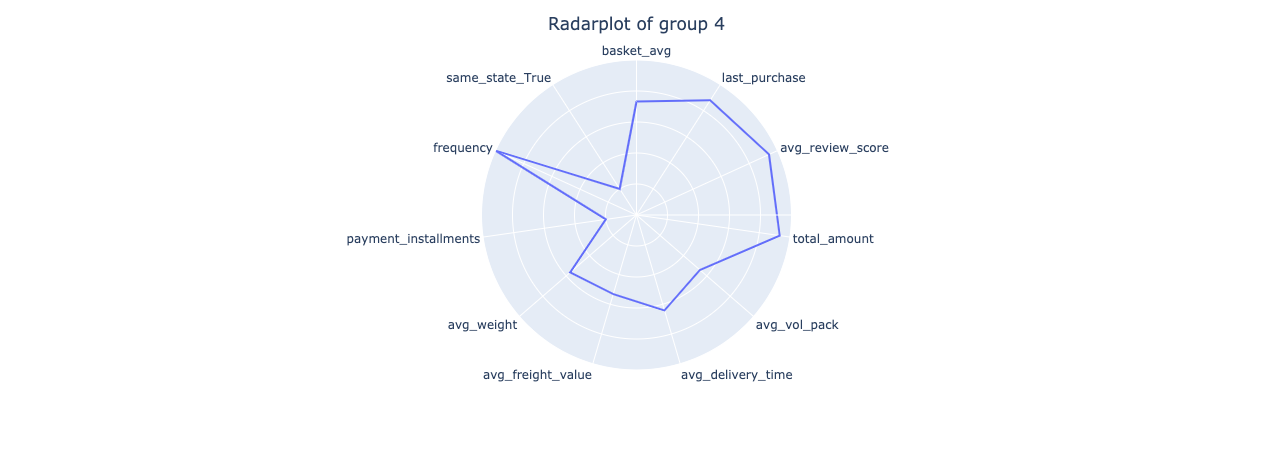

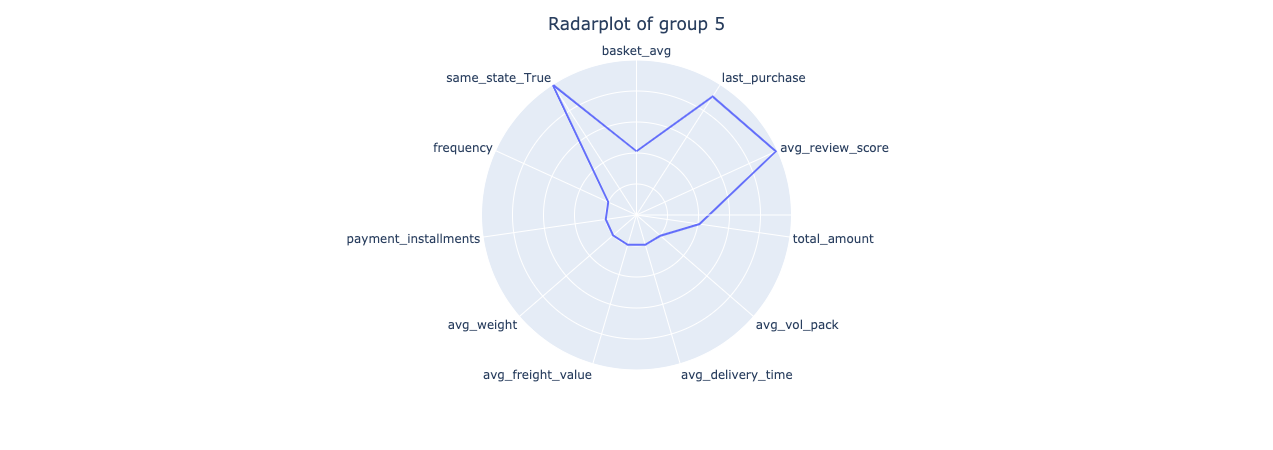

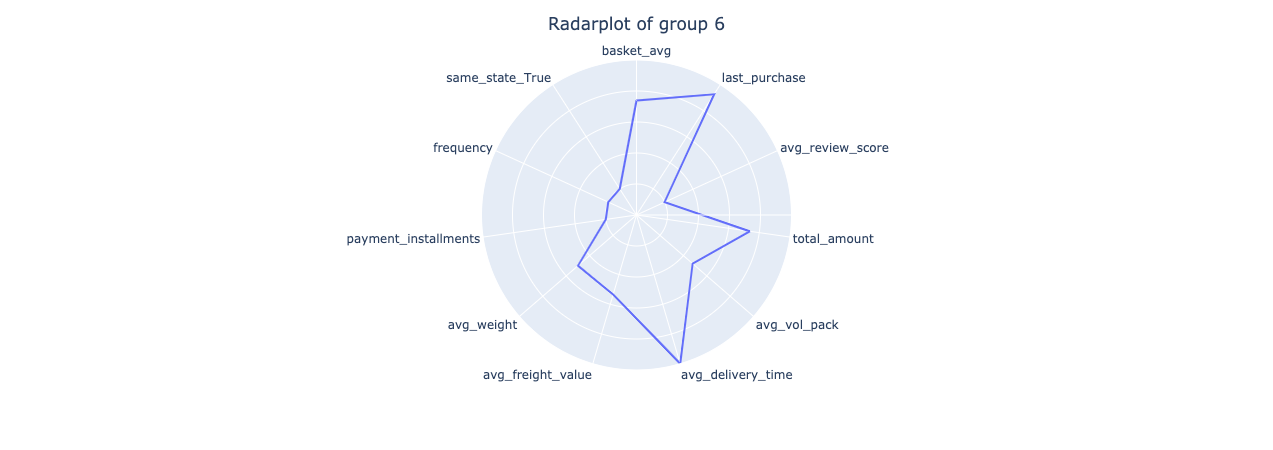

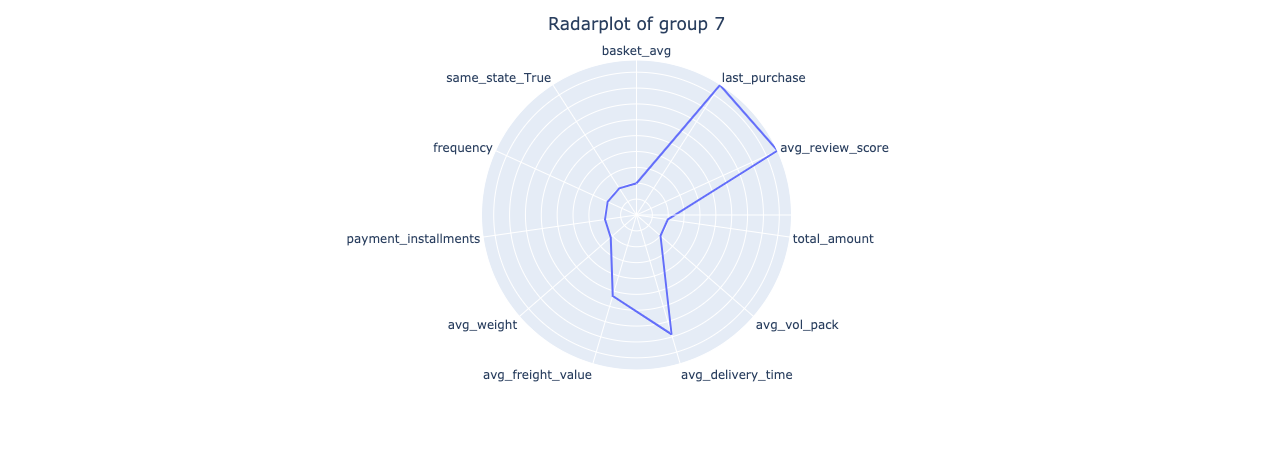

In [67]:
for n in range(0,8) :
    RadarPlot(data=customer, group=n, nb_features=11)

In [41]:
customer.groupby('group').count().iloc[:,0]

group
0    18076
1     9377
2    13976
3     9544
4     4354
5    13556
6     8874
7    16137
Name: basket_avg, dtype: int64

In [42]:
customer.groupby('group').std()

,basket_avg,last_purchase,avg_review_score,total_amount,avg_vol_pack,avg_delivery_time,avg_freight_value,avg_weight,payment_installments,lat,long,frequency
group,,,,,,,,,,,,
0,37517.295313,136.945974,0.697614,37517.295313,15514.959424,6.927716,6.314728,2382.383618,0.609996,4.806853,3.771932,0.000000
1,23049.330980,24.253113,0.821508,23049.330980,9813.277433,3.746091,8.323583,1491.639343,2.097116,4.757608,3.633477,0.000000
2,65660.993441,143.951993,0.754848,65660.993441,11222.030966,6.924338,6.856376,1652.859908,2.631458,5.232418,3.984883,0.000000
3,135902.186654,149.493330,1.217557,144304.347727,42866.504810,10.327660,32.134572,6275.871364,3.357639,6.544780,4.699426,0.032354
4,35199.432688,142.106564,1.087931,80873.773884,16562.215808,7.074626,9.898542,2768.098396,2.667687,5.061749,3.865543,0.639107
5,7652.406227,140.350805,0.922157,7652.373577,6689.511087,3.201384,2.734058,699.529311,1.303907,1.879861,1.637389,0.008589
6,55756.999190,136.763228,0.367838,55756.999190,14392.679821,16.021137,8.883846,2271.871150,2.692946,6.169250,4.328558,0.000000
7,2598.020892,143.732615,0.877568,2597.965946,6956.778693,8.618463,8.001758,871.814623,1.651547,7.440529,5.308400,0.015743


#### Stabilité

In [43]:
# Import des données, application des modications afin d'effectuer des tests sur des sous-parties du dataset

cdir = 'P5/'
files = os.listdir('P5')

# Import

customers = pd.read_csv(cdir + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(cdir + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(cdir + 'olist_order_items_dataset.csv')
order_payements = pd.read_csv(cdir + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(cdir + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(cdir + 'olist_orders_dataset.csv')
products = pd.read_csv(cdir + 'olist_products_dataset.csv')
sellers = pd.read_csv(cdir + 'olist_sellers_dataset.csv')
cat_name = pd.read_csv(cdir + 'product_category_name_translation.csv')

# Merge

temp1 = pd.merge(customers, orders, on='customer_id')
temp2 = pd.merge(temp1, order_items, on='order_id')
temp3 = pd.merge(temp2, order_payements, on='order_id')
temp4 = pd.merge(temp3, order_reviews, on='order_id')
temp5 = pd.merge(temp4, products, on='product_id')
temp6 = pd.merge(temp5, sellers, on='seller_id')
temp7 = pd.merge(temp6, cat_name, on='product_category_name')
df = pd.merge(temp7, geolocation, left_on='customer_zip_code_prefix', 
              right_on='geolocation_zip_code_prefix')

# Création de variables

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['delivery_time'] = df['delivery_time'].dt.days
df['same_state'] = df['geolocation_state'] == df['seller_state']
df['volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

# Sélection

sel = df[['customer_unique_id', 'customer_city', 'customer_state', 'order_id',
          'order_purchase_timestamp', 'order_status','product_id', 'seller_id', 'price',
          'freight_value', 'review_score', 'product_category_name_english',
          'geolocation_lat', 'geolocation_lng',  'payment_type', 'payment_installments',
          'volume', 'product_weight_g', 'delivery_time', 'same_state']]

def CategoryReplacerSeries(to_replace=None, value=None, data=None):
    ### Mapping des nouvelles catégories ###
    for x in to_replace :
        data.replace(x, value, inplace=True)   
        

# Définition des nouvelles catégories
        
technology = ['telephony', 'computers_accessories', 'electronics', 'computers', 'consoles_games',
                'fixed_telephony', 'dvds_blu_ray', 'tablets_printing_image', 'cine_photo']
audio_music = ['audio', 'music', 'musical_instruments', 'cds_dvds_musicals']
food = ['food', 'drinks', 'food_drink', 'la_cuisine']
fashion = ['fashion_childrens_clothes', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_male_clothing',
           'fashion_sport', 'fashio_female_clothing', 'fashion_underwear_beach']
office = ['office_furniture', 'stationery', 'furniture_decor']
home = ['housewares', 'bed_bath_table', 'furniture_living_room', 
        'kitchen_dining_laundry_garden_furniture', 'home_confort', 'furniture_bedroom', 'furniture_mattress_and_upholstery',
       'home_comfort_2']
auto = ['auto']
sport = ['sports_leisure']
children = ['baby', 'toys', 'fashion_childrens_clothes']
misc = ['cool_stuff', 'market_place']
garden = ['garden_tools', 'flowers', 'costruction_tools_garden']
construction = ['construction_tools_construction', 'home_construction', 'construction_tools_safety',
               'costruction_tools_tools', 'construction_tools_lights']
beauty_health = ['health_beauty', 'perfumery', 'diapers_and_hygiene']
gift = ['watches_gifts']
book = ['books_general_interest', 'books_technical', 'books_imported']
pet = ['pet_shop']
appliance = ['home_appliances', 'home_appliances_2', 'air_conditioning', 'small_appliances_home_oven_and_coffee',
            'small_appliances']
business = ['industry_commerce_and_business', 'agro_industry_and_commerce']
art = ['art', 'arts_and_craftmanship']
travel = ['luggage_accessories']
party = ['christmas_supplies', 'party_supplies']
security = ['security_and_services', 'signaling_and_security']

sel.loc[:,'cat'] = sel['product_category_name_english']

list_vars = [technology, audio_music, food, fashion, office, home, auto, sport, children, misc, garden, construction,
             beauty_health, gift, book, pet, appliance, business, art, travel, party, security]
list_names = ['technology', 'audio_music', 'food', 'fashion', 'office', 'home', 'auto', 'sport', 'children', 'misc',
              'garden', 'construction', 'beauty_health', 'gift', 'book', 'pet', 'appliance', 'business', 'art',
              'travel', 'party', 'security']

# Modifications diverses du jeux de données 

def TransformDF(sel=None):
    ### Transformation du jeux de données. ###
    sum_order_by_cust = sel.groupby(['customer_unique_id', 'order_id'])['price'].sum()
    basket_avg = sum_order_by_cust.groupby(['customer_unique_id']).mean()
    
    sel.loc[:,'order_purchase_timestamp'] = pd.to_datetime(sel['order_purchase_timestamp'])
    
    most_recent = sel.groupby('customer_unique_id')['order_purchase_timestamp'].max()
    
    total_amount = sel.groupby('customer_unique_id')['price'].sum()
    
    frequency = sel.groupby('customer_unique_id')['order_id'].nunique()
    
    review_avg = sel.groupby('customer_unique_id')['review_score'].mean()
    
    temp = sel.set_index('customer_unique_id')
    
    cat = sel.loc[:,'cat']
    
    for y in range(len(list_vars)):
        CategoryReplacerSeries(to_replace=list_vars[y], value=list_names[y], data=cat)
        
    sel.loc[:,'cat'] = cat
    
    temp = sel.drop_duplicates(['product_id']).set_index('customer_unique_id')
    
    volume = sel.groupby('customer_unique_id')['volume'].mean()
    
    weight = sel.groupby('customer_unique_id')['product_weight_g'].mean()
    
    payment_inst = sel.groupby('customer_unique_id')['payment_installments'].mean()
    
    payment = sel.groupby('customer_unique_id')['payment_type'].agg(lambda x:x.value_counts().index[0])
    
    delivery = sel.groupby('customer_unique_id')['delivery_time'].mean()
    
    freight = sel.groupby('customer_unique_id')['freight_value'].mean()
    
    distance = sel.groupby('customer_unique_id')['same_state'].agg(lambda x:x.value_counts().index[0])
    
    lat = sel.groupby('customer_unique_id')['geolocation_lat'].agg(lambda x:x.value_counts().index[0])
    
    long = sel.groupby('customer_unique_id')['geolocation_lng'].agg(lambda x:x.value_counts().index[0])

    temp1 = pd.merge(basket_avg, most_recent, left_on=basket_avg.index,
        right_on=most_recent.index)
    temp2 = pd.merge(temp1, review_avg, left_on='key_0',
        right_on=review_avg.index)
    temp3 = pd.merge(temp2, total_amount, left_on='key_0',
        right_on=total_amount.index)
    temp4 = pd.merge(temp3, volume, left_on='key_0',
        right_on=volume.index)
    temp5 = pd.merge(temp4, payment, left_on='key_0',
        right_on=payment.index)
    temp6 = pd.merge(temp5, delivery, left_on='key_0',
        right_on=payment.index)
    temp7 = pd.merge(temp6, distance, left_on='key_0',
        right_on=distance.index)
    temp8 = pd.merge(temp7, freight, left_on='key_0',
        right_on=freight.index)
    temp9 = pd.merge(temp8, weight, left_on='key_0',
        right_on=weight.index)
    temp10 = pd.merge(temp9, payment_inst, left_on='key_0',
        right_on=payment_inst.index)
    temp11 = pd.merge(temp10, lat, left_on='key_0',
        right_on=lat.index)
    temp12 = pd.merge(temp11, long, left_on='key_0',
        right_on=long.index)
    temp13 = pd.merge(temp12, frequency, left_on='key_0',
        right_on=long.index)
    temp13.columns = ['customer_unique_id', 'basket_avg', 'last_purchase', 'avg_review_score',
                      'total_amount','avg_vol_pack', 'payment_type', 'avg_delivery_time',
                      'same_state', 'avg_freight_value', 'avg_weight', 'payment_installments',
                      'lat', 'long', 'frequency']
    customer = pd.merge(temp13, sel[['customer_unique_id', 'cat']], left_on='customer_unique_id',
        right_on='customer_unique_id')
    customer = customer.set_index('customer_unique_id')
    days = customer.last_purchase.max() - customer.last_purchase
    days = days.dt.days

    customer['last_purchase'] = days
    customer = customer.drop_duplicates()
    customer = customer.dropna()
    customer['same_state'] = customer['same_state'].astype('category')
    return customer

In [52]:
# Vérification

customer_test = TransformDF(sel=sel)

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 2min 1s, sys: 11.9 s, total: 2min 13s
Wall time: 2min 14s


In [53]:
# Vérification

from pandas.testing import assert_frame_equal
assert_frame_equal(customer.iloc[:,:-1], customer_test)

AssertionError: DataFrame.iloc[:, 5] (column name="payment_type") are different

DataFrame.iloc[:, 5] (column name="payment_type") values are different (1.30786 %)
[index]: [0000366f3b9a7992bf8c76cfdf3221e2, 0000b849f77a49e4a4ce2b2a4ca5be3f, 0000f46a3911fa3c0805444483337064, 0000f6ccb0745a6a4b88665a16c9f078, 0004aac84e0df4da2b147fca70cf8255, 0004bd2a26a76fe21f786e4fbd80607f, 00050ab1314c0e55a6ca13cf7181fecf, 00053a61a98854899e70ed204dd4bafe, 0005e1862207bf6ccc02e4228effd9a0, 0005ef4cd20d2893f0d9fbd94d3c0d97, 0006fdc98a402fceb4eb0ee528f6a8d4, 00082cbe03e478190aadbea78542e933, 00090324bbad0e9342388303bb71ba0a, 000949456b182f53c18b68d6babc79c1, 000a5ad9c4601d2bbdd9ed765d5213b3, 000bfa1d2f1a41876493be685390d6d3, 000c8bdb58a29e7115cfc257230fb21b, 000d460961d6dbfa3ec6c9f5805769e1, 000de6019bb59f34c099a907c151d855, 000e309254ab1fc5ba99dd469d36bdb4, 000ec5bff359e1c0ad76a81a45cb598f, 000ed48ceeb6f4bf8ad021a10a3c7b43, 000fbf0473c10fc1ab6f8d2d286ce20c, 000fbf0473c10fc1ab6f8d2d286ce20c, 0010a452c6d13139e50b57f19f52e04e, 0010fb34b966d44409382af9e8fd5b77, 001147e649a7b1afd577e873841632dd, 00115fc7123b5310cf6d3a3aa932699e, 0011805441c0d1b68b48002f1d005526, 0011857aff0e5871ce5eb429f21cdaf5, 0011c98589159d6149979563c504cb21, 0012929d977a8d7280bb277c1e5f589d, 0014a5a58da615f7b01a4f5e194bf5ea, 0015752e079902b12cd00b9b7596276b, 00172711b30d52eea8b313a7f2cced02, 00191a9719ef48ebb5860b130347bf33, 001926cef41060fae572e2e7b30bd2a4, 001928b561575b2821c92254a2327d06, 00196c4c9a3af7dd2ad10eade69c926f, 00196fdb2bf9edfc35e88ebfbcf8d781, 0019da6aa6bcb27cc32f1249bd12da05, 0019e8c501c85848ac0966d45226fa1d, 001a2bf0e46c684031af91fb2bce149d, 001a34eb30ecb8e3aacb07c475ca4dd1, 001a3a8e11d76c9a366c31a4aa2cc529, 001ae5a1788703d64536c30362503e49, 001deb796b28a3a128d6113857569aa4, 001f3c4211216384d5fe59b041ce1461, 002043098f10ba39a4600b6c52fbfe3c, 002311514717ca8b65b09a26cdf7b91a, 0023557a94bef0038066b5d1b3dc763e, 002471155ecd08d208d1376720e2a907, 00256bf7b05c08f6a5849df3d0a64f1f, 0025795df7a7d077c4c90162fa820085, 0027324a96d26a2bc7d69262f83c8403, 0028a7d8db7b0247652509358ad8d755, 0028cfeb9dfcd3628a56d5b6400deef5, 00293787e2aec37a9c253b63fdfe2049, 002aba8c1af80acacef6e011f9f23262, 002ae492472e45ad6ebeb7a625409392, 002b4cd83fabaffaa475f78ea5ef3e08, 002bdeb33da5b1b3ce8b9c822f749c82, 002cdf87d4c03f08f7eb4551a923affc, 002d3bd901608f67c3fc11eaaa842b13, 002d71b244beb91ca7030b15ab526446, 002da6dde369f6a8b4c999ed61eb5a87, 002eb8b96288f3804e21d2777ac29895, 002ed12115742033f015cb3c269ccf68, 002ef00822613c94613e60e03b169fef, 002feefec5af0a3b26ee7839c66d205e, 003035f5ec76f2220098377482de93c9, 003162bf0351f47a1a247992b8b9b42d, 00324c9f4d710e7bac5c5ba679714430, 0032c76b20340da25249092a268ce66c, 0032ca69771a7758ce643258bb9e4ac7, 0033f4a2887e07e25aa1204d482f41ba, 00344274804f3b8003de1b0562ae01df, 0034c76b7e6a17d738375b99afc2f01e, 0035029989e6fc5cf030918a5f9f2037, 003650b504826ea534e02eba0ab58dd5, 0036a074f98b80c4f1fc33dbbcf9c552, 0036b4a3d09ad551a5188c2e374da402, 0036d365b138cc0ee06bed755bcb5044, 00370dfde3d012c420d29657afc2fc8b, 00377a18050b898b93e2c774be9947db, 0037aa56b017c105c3a9d47af71fff98, 0037d2bbb9ebc39d9114aea27ee16d72, 0037eb1ff742ee2e71ba887f65f3c6f3, 003800162424b7b5b3d75c9cf22a66e7, 00391594070baf8603f5fdc1d0c6a48c, 003a5571a07dcf09bf117d13d2980ba3, 003a7a8eb096ed3cbf713d2def1ca701, 003ac9408252444b489b1bfc013f5f8c, 003ae409f37c3c30cb1c974af3a42692, 003c2067070f5b3d923235b1ea1cc17b, 003c457932a554e4df13834237b1ed00, 003d56767e53e08671de00da3fba8d40, 003db7adfcdc49857b095a50191b6c9d, 003e28cb6fab8a0901bff9229612375f, 003e2af81ea3c72fbdd093f07724a4de, ...]
[left]:  [credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, voucher, boleto, credit_card, boleto, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, voucher, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, boleto, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, boleto, boleto, boleto, credit_card, credit_card, credit_card, credit_card, ...]
[right]: [credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, voucher, boleto, credit_card, boleto, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, voucher, boleto, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, boleto, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, boleto, credit_card, credit_card, credit_card, boleto, credit_card, credit_card, credit_card, credit_card, boleto, credit_card, boleto, boleto, boleto, credit_card, credit_card, credit_card, credit_card, ...]

In [56]:
# Comparaison de l'ARI à J+1

mask2017 = sel.order_purchase_timestamp < pd.to_datetime(datetime.date(year = 2018, month = 1, day = 1))
sel2017 = sel[mask2017]

mask2017_plus = sel.order_purchase_timestamp < pd.to_datetime(datetime.date(year = 2018, month = 1, day = 2))
sel2017_plus = sel[mask2017_plus]


customer_2017 = TransformDF(sel=sel2017)
customer_2017_plus_1 = TransformDF(sel=sel2017_plus)

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

CPU times: user 1min 50s, sys: 6.58 s, total: 1min 57s
Wall time: 1min 59s


In [57]:
def kmeans_pipe(data=None, n_clusters=n_clusters):
    
    ### Attribution des labels ###
    
    kmeans = cluster.KMeans(n_clusters = n_clusters, random_state=42)
    k_pipe = pipeline.make_pipeline(preprocessor, kmeans).fit(data)
    pred = k_pipe.predict(data)
    return pred

In [58]:
# Comparaison de l'ARI à J+1

pred_2017 = kmeans_pipe(data=customer_2017, n_clusters=8)
pred_2017_plus_1 = kmeans_pipe(data=customer_2017_plus_1, n_clusters=8)

customer_2017['pred_2017'] = pred_2017
customer_2017_plus_1['pred_2017_plus_1'] = pred_2017_plus_1

test = pd.merge(customer_2017['pred_2017'], customer_2017_plus_1['pred_2017_plus_1'], left_index=True, right_index=True)

metrics.adjusted_rand_score(test['pred_2017'], test['pred_2017_plus_1'] )

0.9903876758164643

In [59]:
# Comparaison de l'ARI à 6 mois

mask2017_6m = sel.order_purchase_timestamp < pd.to_datetime(datetime.date(year = 2018, month = 3, day = 1))
sel2017_6m = sel[mask2017_6m]
customer_6m= TransformDF(sel=sel2017_6m)
pred_6m = kmeans_pipe(data=customer_6m, n_clusters=8)
customer_6m['pred_6m'] = pred_6m
test = pd.merge(customer_2017['pred_2017'], customer_6m['pred_6m'], left_index=True, right_index=True)
metrics.adjusted_rand_score(test['pred_2017'], test['pred_6m'] )

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.7725990443031933

In [60]:
def ComputeAri(year=None, month=None, day=None, df_to_comp=customer_2017, col ='pred_2017'):
    
    ### Calcul le score ARI entre deux jeux de données ###
    
    mask = sel.order_purchase_timestamp < pd.to_datetime(datetime.date(year = year, month = month, day = day))
    temp_sel= sel[mask]
    temp_customer= TransformDF(sel=temp_sel)
    pred_temp = kmeans_pipe(data=temp_customer, n_clusters=8)
    temp_customer['pred_temp'] = pred_temp
    test = pd.merge(df_to_comp[col], temp_customer['pred_temp'], left_index=True, right_index=True)
    score = metrics.adjusted_rand_score(test[col], test['pred_temp'] )
    return score

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/jeremy/opt/miniconda3/envs/jvds/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

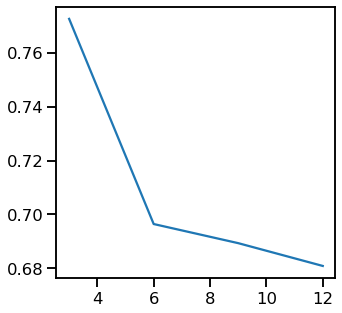

In [76]:
# Evolution du score ARI sur 1 an

ari_list = []

for n in [3,6,9,12] :
    ari = ComputeAri(year=2018, month=n, day=1, df_to_comp=customer_2017, col ='pred_2017')
    ari_list.append(ari)
    


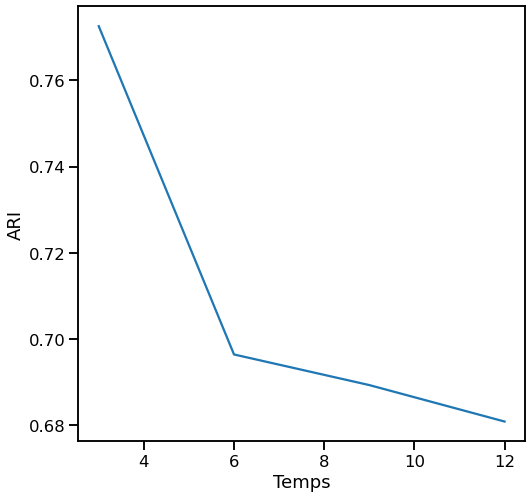

In [79]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot([3,6,9,12], ari_list)
ax.set_xlabel('Temps')
ax.set_ylabel('ARI')
plt.show()

In [70]:
ari_list

[0.7725990443031933,
 0.6964217083809665,
 0.6893194878588863,
 0.6808577981417101]

## DBScan

In [99]:
# OPTICS avec des paramètres standards

db = cluster.OPTICS(min_samples=50, xi=.1, min_cluster_size=.1)

pipeline_db = pipeline.make_pipeline(preprocessor_sparse, db)

pred_db = pipeline_db.fit_predict(X)

display_factorial_planes_sns(X_projected, n_comp, pipeline_pca[1], [(0,1),(2,3),(4,5)], illustrative_var=pred_db, cmap=None, title='Projection_indiv')